In [36]:
import pandas as pd
import numpy as np

from datetime import timedelta

from TAcharts.utils import group_candles

In [37]:
eth_1h = pd.read_csv('../data/ETH.csv')
eth_1h.head()

,date,open,high,low,close,volume
0,2019-01-01 00:00:00,132.74,133.50,132.67,133.36,6204.28401
1,2019-01-01 01:00:00,133.36,134.30,133.01,133.56,10214.95098
2,2019-01-01 02:00:00,133.56,135.30,133.19,134.52,16342.20664
3,2019-01-01 03:00:00,134.55,134.78,133.55,133.70,14895.35710
4,2019-01-01 04:00:00,133.72,134.14,133.66,133.86,6388.10191


In [38]:
# Group ETH into 1d candles
eth_1d = group_candles(eth_1h, interval=24)
eth_1d

,date,open,high,low,close,volume
0,2019-01-01 00:00:00,132.74,140.67,131.00,138.99,4.151021e+05
1,2019-01-02 00:00:00,138.91,155.37,138.30,151.93,1.018141e+06
2,2019-01-03 00:00:00,151.78,154.20,143.11,153.33,7.381434e+05
3,2019-01-04 00:00:00,153.11,159.26,144.66,154.51,8.914434e+05
4,2019-01-05 00:00:00,157.70,157.80,147.51,150.47,6.645218e+05
...,...,...,...,...,...,...
325,2019-11-23 02:00:00,150.00,154.33,146.60,150.02,3.124310e+05
326,2019-11-24 02:00:00,149.34,151.20,131.45,143.69,6.116189e+05
327,2019-11-25 04:00:00,137.37,151.50,136.79,146.76,5.985306e+05
328,2019-11-26 04:00:00,146.77,148.72,140.84,142.72,3.943000e+05


## Determine Rebalance Dates
### Daily Volatility

In [39]:
def calc_pct_change(high, low, _open):
    return (high - low) / _open

In [40]:
eth_1d['pct_change'] = calc_pct_change(eth_1d['high'], eth_1d['low'], eth_1d['open'])
eth_1d['weekday'] = pd.DatetimeIndex(eth_1d['date']).day_name()

daily_volatility = eth_1d.groupby('weekday')['pct_change'].mean().sort_values(ascending=False)
print(daily_volatility)

weekday
Tuesday      0.070740
Wednesday    0.066079
Sunday       0.063304
Monday       0.062416
Friday       0.061621
Thursday     0.059621
Saturday     0.052946
Name: pct_change, dtype: float64


### Hourly Volatility

In [41]:
eth_1h['pct_change'] = calc_pct_change(eth_1h['high'], eth_1h['low'], eth_1h['open'])
eth_1h['hour'] = pd.DatetimeIndex(eth_1h['date']).hour

# Only take volatility from Saturday
eth_1h_saturday = eth_1h[pd.DatetimeIndex(eth_1h['date']).day_name() == 'Saturday']

hourly_volatility = eth_1h.groupby('hour')['pct_change'].mean().sort_values(ascending=False)
print(hourly_volatility)

hour
11    0.015472
19    0.014008
10    0.013859
9     0.013478
18    0.013072
17    0.012644
8     0.012570
15    0.012349
7     0.012239
16    0.011714
5     0.011542
12    0.011506
4     0.011314
3     0.011192
6     0.011139
14    0.010986
20    0.010895
13    0.010425
23    0.010207
22    0.010100
21    0.010055
2     0.010032
0     0.009698
1     0.009190
Name: pct_change, dtype: float64


### Conclusion
Now that we know that Saturday is the least volatile day and during Saturday hour 1 is the least volatile hour, we can set our fixed rebalance date to every Saturday at 1:00.

In [53]:
# Add boolean value to rebalance based on weekday and hour with least volatility

is_weekday = pd.DatetimeIndex(eth_1h['date']).day_name() == 'Saturday'
is_hour = pd.to_datetime(eth_1h['date']).apply(lambda x: x.hour == 1 and x.minute == 0)

eth_1h['rebalance'] = is_weekday & is_hour

## Determine Signals

In [43]:
from TAcharts.indicators import sma

sma_200 = sma(eth_1h['close'], n=200)
sma_100 = sma(eth_1h['close'], n=100)
sma_50 = sma(eth_1h['close'], n=50)

bullish = (sma_50 > sma_100) & (sma_100 > sma_200)
bearish = (sma_50 < sma_100) & (sma_100 < sma_200)

eth_1h['signal'] = ['bull' if bullish[i] else 'bear' if bearish[i] else 'neutral' for i in range(len(eth_1h))]

# Dates of rebalance and signal
eth_1h[['date', 'signal']].loc[eth_1h['rebalance']]

,date,signal
97,2019-01-05 01:00:00,neutral
265,2019-01-12 01:00:00,bear
433,2019-01-19 01:00:00,bear
601,2019-01-26 01:00:00,bear
769,2019-02-02 01:00:00,neutral
937,2019-02-09 01:00:00,bull
1105,2019-02-16 01:00:00,neutral
1273,2019-02-23 01:00:00,bull
1441,2019-03-02 01:00:00,bear
1609,2019-03-09 01:00:00,bull


In [45]:
eth_1h['signal'].loc[eth_1h['rebalance']].value_counts()

neutral    20
bear       14
bull       13
Name: signal, dtype: int64

## Backtest
### Setup

In [50]:
class Portfolio:
    
    trade_count = 0
    initial_capital = 10000
    wiggle_room = 0.05
    slippage = 0.008
    
    def __init__(self, coins, start_prices):
        
        capital_each = self.initial_capital / len(coins)
        units = capital_each / start_prices
        self.units = units
        self.start_units = units.copy()
        
        self.coins = coins
        self.start_prices = start_prices

In [47]:
allocations = {
    'bull': [0.75, 0.25],
    'neutral': [0.50, 0.50],
    'bear': [0.25, 0.75]
}


df = eth_1h[['date', 'rebalance', 'signal', 'close']].rename({'close': 'ETH'}, axis=1)

# Add DAI column and set to 1 as DAI price stays constant at 1
df['DAI'] = 1

In [48]:
coins = ['ETH', 'DAI']
start_prices = df[coins].iloc[0]

p = Portfolio(coins, start_prices)

running_totals = pd.DataFrame(columns=[
    '50/50 ETH-DAI: Without rebalancing',
    '50/50 ETH-DAI: With rebalancing',
])



for _, row in df.iterrows():
    
    current_prices = row[coins]
    
    if row['rebalance']:
        
        # Calculate weighting based on current prices
        dollar_values = p.units * current_prices
        
        weights_current = dollar_values / sum(dollar_values)
        weights_preferred = allocations[row['signal']]
        
        # Calculate weight to trade from each side
        trade_weights = (weights_preferred - weights_current) / 2
        
        # Make sure trade size is larger than our wiggle_room criteria
        is_trade_actionable = sum(abs(weight) > p.wiggle_room for weight in trade_weights) == len(coins)
        
        if is_trade_actionable:
            
            trade_dollar_values = trade_weights * sum(dollar_values)
            
            trade_units = trade_dollar_values / current_prices
            # NOTE: divide slippage by 2 to account for 50% slippage on each side
            trade_units_after_slippage = (1 - p. slippage/2) * trade_units
            
            # Update porfolio units with added/subtracted units
            p.units += trade_units_after_slippage
            
            # Update trade count
            p.trade_count += 1

            
    # Update running totals of rebalances
    running_totals = running_totals.append({
        '50/50 ETH-DAI: Without rebalancing': sum(p.start_units * current_prices),
        '50/50 ETH-DAI: With rebalancing': sum(p.units * current_prices),
    }, ignore_index=True)
    

## Comparison

In [49]:
print(round(running_totals.iloc[-1]))

50/50 ETH-DAI: Without rebalancing    10687.0
50/50 ETH-DAI: With rebalancing       12054.0
Name: 7939, dtype: float64


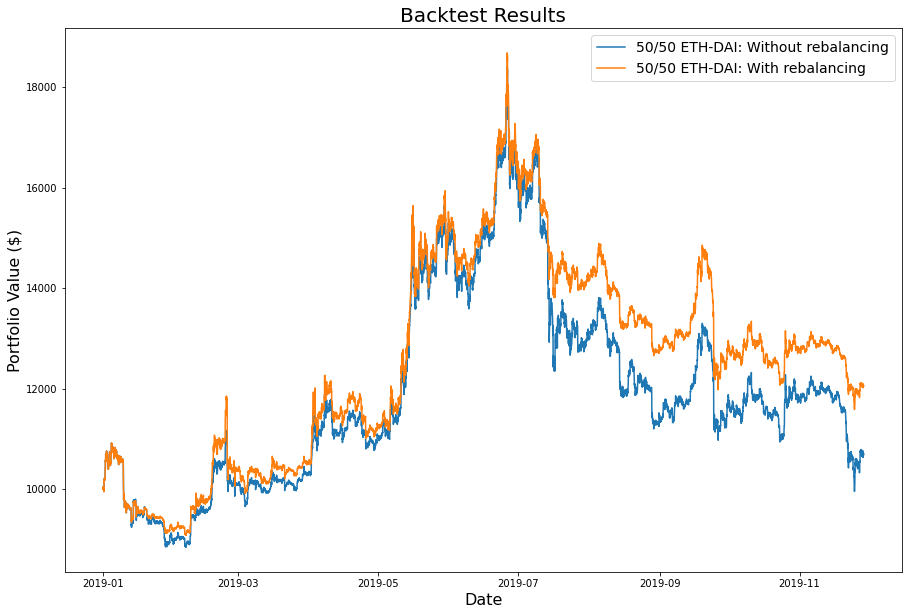

In [52]:
import matplotlib.pyplot as plt

# Set dates as index for running totals
running_totals.index = pd.DatetimeIndex(df['date'])


fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(running_totals)

ax.legend(running_totals.columns, loc='upper right', fontsize=14)
ax.set_ylabel('Portfolio Value ($)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Backtest Results', fontsize=20)

plt.show()